In [10]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, fbeta_score
from joblib import dump, load

In [2]:
DATA_PATH = "data/metrics.db"

In [5]:
def load_data(data_path):
    conn = sqlite3.connect(data_path)
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM metrics")
    rows = cursor.fetchall()
    conn.close()

    df = pd.DataFrame(rows, columns=[
        'id', 'author', 'numberLinesOfCodeBef', 'numberCommentsBef',
        'numberBlankLinesBef', 'totalLinesBef', 'numParametersBef',
        'numStatementsBef', 'halsteadLengthBef', 'halsteadVocabularyBef',
        'halsteadVolumeBef', 'halsteadDifficultyBef', 'halsteadEffortBef',
        'halsteadLevelBef', 'halsteadTimeBef', 'halsteadBugsDeliveredBef',
        'halsteadMaintainabilityBef', 'cyclomaticComplexityBef',
        'cognitiveComplexityBef', 'lackOfCohesionInMethodBef',
        'numberLinesOfCodeAfter', 'numberCommentsAfter', 'numberBlankLinesAfter',
        'totalLinesAfter', 'numParametersAfter', 'numStatementsAfter',
        'halsteadLengthAfter', 'halsteadVocabularyAfter', 'halsteadVolumeAfter',
        'halsteadDifficultyAfter', 'halsteadEffortAfter', 'halsteadLevelAfter',
        'halsteadTimeAfter', 'halsteadBugsDeliveredAfter', 'halsteadMaintainabilityAfter',
        'cyclomaticComplexityAfter', 'cognitiveComplexityAfter', 'lackOfCohesionInMethodAfter'
    ])
    
    return df

In [7]:
data = load_data(DATA_PATH)
data = data.drop(columns='author')
data.head()

,id,numberLinesOfCodeBef,numberCommentsBef,numberBlankLinesBef,totalLinesBef,numParametersBef,numStatementsBef,halsteadLengthBef,halsteadVocabularyBef,halsteadVolumeBef,...,halsteadVolumeAfter,halsteadDifficultyAfter,halsteadEffortAfter,halsteadLevelAfter,halsteadTimeAfter,halsteadBugsDeliveredAfter,halsteadMaintainabilityAfter,cyclomaticComplexityAfter,cognitiveComplexityAfter,lackOfCohesionInMethodAfter
0,1,57,0,5,62,2,55,77.0,321.0,482.542564,...,104.041925,2.145161,223.186710,0.466165,12.399262,0.000333,75.333072,1,1,1.000000
1,2,4,0,2,6,2,2,45.0,91.0,247.133389,...,104.041925,2.015152,209.660243,0.496241,11.647791,0.000333,75.333072,1,1,1.000000
2,3,3,0,2,5,2,1,21.0,36.0,92.238666,...,104.041925,2.145161,223.186710,0.466165,12.399262,0.000333,75.333072,1,1,1.000000
3,4,3,0,0,3,1,1,29.0,40.0,140.881449,...,122.211433,5.055556,617.846687,0.197802,34.324816,0.000333,74.843607,1,1,0.333333
4,5,11,0,0,11,2,6,26.0,49.0,122.211433,...,80.710623,1.956522,157.912088,0.511111,8.772894,0.000333,76.105237,1,1,1.000000


C:\Users\dluis\AppData\Local\Temp\ipykernel_74544\3697290510.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_numberLinesOfCode'] = df['numberLinesOfCodeAfter'] - df['numberLinesOfCodeBef']
C:\Users\dluis\AppData\Local\Temp\ipykernel_74544\3697290510.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_numberComments'] = df['numberCommentsAfter'] - df['numberCommentsBef']
C:\Users\dluis\AppData\Local\Temp\ipykernel_74544\3697290510.py:5: SettingWithCopyWarning: 
A value is trying to be s

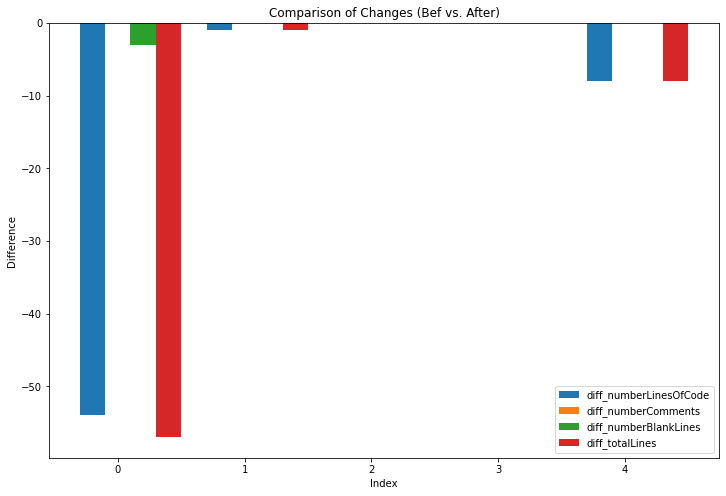

In [15]:
df = data.head()

df['diff_numberLinesOfCode'] = df['numberLinesOfCodeAfter'] - df['numberLinesOfCodeBef']
df['diff_numberComments'] = df['numberCommentsAfter'] - df['numberCommentsBef']
df['diff_numberBlankLines'] = df['numberBlankLinesAfter'] - df['numberBlankLinesBef']
df['diff_totalLines'] = df['totalLinesAfter'] - df['totalLinesBef']

plt.figure(figsize=(12, 8))
diff_columns = ['diff_numberLinesOfCode', 'diff_numberComments', 'diff_numberBlankLines', 'diff_totalLines']
bar_width = 0.2
index = df.index

for i, col in enumerate(diff_columns):
    plt.bar(index + (i * bar_width), df[col], width=bar_width, label=col)

plt.xlabel('Index')
plt.ylabel('Difference')
plt.title('Comparison of Changes (Bef vs. After)')
plt.xticks(index + bar_width, index)
plt.legend(diff_columns)
plt.show()

In [16]:
from time import localtime, strftime
strftime("%Y-%m-%d %H:%M:%S", localtime())

'2024-05-06 10:17:31'